In [78]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,  LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, precision_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.datasets import make_classification
import xgboost as xgb
from classification_model import xgb_classification, lgb_classification_2, svm_classification_2, calculate_precision
rus = RandomUnderSampler(random_state=2021)

In [79]:
def train_plt(score):
    plt.barh(y=range(1, len(score)), width=score)
    plt.ylabel('epoch',fontsize=14)
    plt.xlabel('precision',fontsize=14)
    return np.mean(score), np.std(score)

In [80]:
def get_real_no():
    no = []
    with open('hands_no.txt') as f:
        for i in f.readlines():
            lines = i.strip().split(' ')
            win_no = lines[-1]
            for j in lines[:-1]:
                no.append('{}_{}_-1'.format(j, win_no))
    return no
no = get_real_no()



In [95]:
df = pd.read_csv('res/final_13.csv')

In [82]:
origin_data = pd.read_csv('../res/res.csv')
origin_data = origin_data[origin_data.columns[1:]]
origin_data['len_trace'] = origin_data['end'] - origin_data['start'] + 1
origin_data.head()

,no,win_no,start,end,parent,frame_no,axis_x,axis_y,girth,girth_full,...,hu_m5,hu_m6,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,len_trace
0,1_02_-1,2,0,45,0_02_-1,0,664.750061,29.749968,161.865004,163.865004,...,0.000523,1.453520e-09,3.234091,0.042158,0.998660,0.998582,0.820172,0.997166,0,46
1,1_02_-1,2,0,45,0_02_-1,1,662.500061,28.499977,148.965510,153.965510,...,0.000153,3.327892e-09,2.791609,0.038952,0.998690,0.998602,0.816545,0.997205,0,46
2,1_02_-1,2,0,45,0_02_-1,2,662.073181,28.841480,148.722870,153.722870,...,0.000288,1.791276e-08,2.878099,0.038858,0.998683,0.998595,0.814135,0.997191,0,46
3,1_02_-1,2,0,45,0_02_-1,3,661.451233,28.439020,145.308655,150.308655,...,0.000078,1.473819e-08,2.831595,0.039124,0.998702,0.998612,0.817924,0.997227,0,46
4,1_02_-1,2,0,45,0_02_-1,4,661.500061,27.999968,146.308657,150.308657,...,0.000239,2.107708e-08,2.712877,0.040664,0.998603,0.998525,0.813886,0.997052,0,46


In [96]:
def read_data_to_train(df, ile='../res/final_13.csv'):
    # df = pd.read_csv(file)
    y = df['label']
    no = df['no']
#     df['id'] = list(range(df.shape[0]))
    no_cols = ['Unnamed: 0', 'label', 'no', 'id']
    # df = df[[i for i in df.columns if i not in no_cols]]
    print(df.shape)
    pca = PCA(n_components=0.9)
    X = pca.fit_transform(df[[i for i in df.columns if i not in no_cols]])
    X = pd.DataFrame(data=X, columns=list(range(X.shape[1])))
    X['no'] = no
    X['label'] = y
    X['id'] = list(range(df.shape[0]))
    print(X.shape)
    p_no = df[df['label'] == 1]['no'].drop_duplicates()

    ## 将所有正例作为验证集合
    all_p = X[X['no'].isin(p_no)]
    part_np = X[~X['no'].isin(p_no)].sample(n=all_p.shape[0], replace=False, random_state=2021)
    all_val = pd.concat([all_p, part_np])

    val_no = p_no.sample(n=p_no.shape[0]//10, replace=False, random_state=2021)
    print(val_no.shape, p_no.shape)
    p_no = p_no[~ p_no.isin(val_no)]
    # print(p_no)
    val_X = X[X['no'].isin(val_no)]
    trn_X = X[~ X['no'].isin(val_no)]
    feat = [i for i in trn_X.columns if i not in ['label', 'no']]
    trn_X['id2'] = list(range(trn_X.shape[0]))
    X_resampled, y_resampled = rus.fit_resample(trn_X, trn_X['label'])
    trn_no = X_resampled['id2'].drop_duplicates()
    print(trn_no.shape, p_no.shape)
    # a = trn_X[~trn_X['no'].isin(trn_no)]
    a = trn_X[~trn_X['id2'].isin(trn_no)]
    print(sorted(Counter(y_resampled).items()),
          trn_X.shape, trn_no.shape, a.shape, val_X.shape)
    val_X_np = a.sample(n=val_X.shape[0], replace=False, random_state=2021)
    print(val_X_np[val_X_np['label'] == 1]['no'].drop_duplicates().shape)
    val_X = pd.concat([val_X, val_X_np])
    return val_X, X_resampled, y_resampled, feat, all_val


In [97]:
val_X, X_resampled, y_resampled, feat, all_val = read_data_to_train(df, 'res/final_13.csv')

(26329, 446)
(26329, 18)
(31,) (316,)
(10340,) (285,)
[(0, 5170), (1, 5170)] (25877, 19) (10340,) (15537, 19) (452, 18)
(0,)


/tmp/ipykernel_218629/1096504090.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trn_X['id2'] = list(range(trn_X.shape[0]))


In [92]:
all_val.to_csv('all_val.csv', index=False)

In [100]:
df.head()

,Unnamed: 0,no,axis_x,axis_y,girth,girth_full,area,elongation,eccentricity,convexity,...,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_sum,distance
0,0,1001_35_-1,172.923065,124.384598,56.355338,57.355338,141.5,-2.157556,0.948526,1.160555,...,1.421513,1.581158,0.999980,0.316221,0.316237,0.999992,0.806214,0.412306,4.967586,9.690323
1,1,1001_35_-1,173.400009,124.800003,58.769552,62.769552,197.0,-1.580986,0.921891,1.168449,...,0.999980,0.316221,0.316237,0.999992,0.806214,0.412306,0.670814,0.582803,4.153104,10.039340
2,2,1090_35_-1,160.880005,131.339996,53.870057,56.870057,206.5,-0.681903,0.804048,1.216809,...,1.060660,0.500000,8.513782,0.335000,0.338663,0.857214,0.364281,0.297795,11.168884,17.567078
3,3,1090_35_-1,162.000000,130.000000,58.870057,60.870057,239.5,-0.542389,0.761347,1.182848,...,8.513782,0.335000,0.338663,0.857214,0.364281,0.297795,0.492527,0.401686,10.183136,15.929362
4,4,1091_35_-1,155.280823,158.917801,114.154328,115.154328,818.5,-0.119862,0.450121,1.168843,...,1.445862,0.353562,1.114765,0.683001,1.196618,1.404376,0.780883,1.581139,3.271400,12.007259


In [101]:
df.shape

(26329, 446)

In [86]:
%load_ext autoreload
%autoreload 2
all_real_no = all_val['no'].drop_duplicates()
all_val.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(11244, 18)

In [87]:
val_no = val_X[val_X['label'] == 1]['no'].drop_duplicates()
val_no.shape

(31,)

In [88]:
feat

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'id']

In [59]:
svm_clf = Pipeline(
    (
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel='rbf', C=10, gamma=0.1))
    )
)
y_predict, y_true = svm_classification_2(X_resampled, svm_clf, feat)
a = svm_clf.predict(val_X[feat])
print(calculate_precision(a, val_X['label']))

epoch 0 precision_score 0.8546950145634356
epoch 1 precision_score 0.824279578216889
epoch 2 precision_score 0.8122271334309342
epoch 3 precision_score 0.837158946261553
epoch 4 precision_score 0.7956076767438662
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
466 575
0.8104347826086956


In [60]:
a = svm_clf.predict(all_val[feat])
print(calculate_precision(a, all_val['label']))

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
5037 5971
0.8435772902361414


In [61]:
a, d,e, f = lgb_classification_2(X_resampled, all_val[feat], feat)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.919858
[200]	valid_0's precision: 0.9252
[300]	valid_0's precision: 0.926981
Early stopping, best iteration is:
[214]	valid_0's precision: 0.931434
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.904175
Early stopping, best iteration is:
[1]	valid_0's precision: 0.906072
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.942806
Early stopping, best iteration is:
[2]	valid_0's precision: 0.946381
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.998843
Early stopping, best iteration is:
[1]	valid_0's precision: 0.998843
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.96861
Early stopping, best iteration is:
[1]	valid_0's precision: 0.980942
feature importance:
feature
id    28679.454614
11      281.567749
0       164.950945
6       1

In [62]:
x = np.mean(d, axis=0)
x = x > 0.5
print(calculate_precision(x, all_val['label']))

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
4019 4300
0.9346511627906977


In [63]:
np.sum(all_val[(all_val['label'] == 1) & (all_val['label'] == x)]['label'])

4019

In [64]:
a = xgb_classification(X_resampled, val_X[feat], feat)

[0]	train-auc:0.999834	valid-auc:0.987093	train-precision:0.999745	valid-precision:0.975957
Multiple eval metrics have been passed: 'valid-precision' will be used for early stopping.

Will train until valid-precision hasn't improved in 100 rounds.


[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=8
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[15:08:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes,

[100]	train-auc:0.999999	valid-auc:0.991048	train-precision:0.999745	valid-precision:0.975957
Stopping. Best iteration:
[5]	train-auc:0.995514	valid-auc:0.958202	train-precision:0.978366	valid-precision:0.914515



[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 2 pruned nodes, max_depth=8
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[15:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7


epoch 0 precision : 0.9210762331838565
[0]	train-auc:0.999813	valid-auc:0.977648	train-precision:0.998249	valid-precision:0.934535
Multiple eval metrics have been passed: 'valid-precision' will be used for early stopping.

Will train until valid-precision hasn't improved in 100 rounds.


[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 2 pruned nodes, max_depth=8
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 2 pruned nodes, max_depth=8
[15:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, 

[100]	train-auc:0.999999	valid-auc:0.964627	train-precision:0.998749	valid-precision:0.934535
Stopping. Best iteration:
[0]	train-auc:0.999813	valid-auc:0.977648	train-precision:0.998249	valid-precision:0.934535

epoch 1 precision : 1.0
[0]	train-auc:0.674597	valid-auc:0.549394	train-precision:0.475973	valid-precision:0.336908
Multiple eval metrics have been passed: 'valid-precision' will be used for early stopping.

Will train until valid-precision hasn't improved in 100 rounds.


[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 4 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[15:08:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, 

[100]	train-auc:0.999999	valid-auc:0.978076	train-precision:0.997966	valid-precision:0.941912
Stopping. Best iteration:
[0]	train-auc:0.674597	valid-auc:0.549394	train-precision:0.475973	valid-precision:0.336908

epoch 2 precision : 0.526536312849162
[0]	train-auc:0.658939	valid-auc:0.531546	train-precision:0.624403	valid-precision:0.47338
Multiple eval metrics have been passed: 'valid-precision' will be used for early stopping.

Will train until valid-precision hasn't improved in 100 rounds.


[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 4 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[15:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes,

[100]	train-auc:0.999997	valid-auc:0.995463	train-precision:0.998329	valid-precision:0.998843
Stopping. Best iteration:
[0]	train-auc:0.658939	valid-auc:0.531546	train-precision:0.624403	valid-precision:0.47338

epoch 3 precision : 0.46006749156355453
[0]	train-auc:0.999838	valid-auc:0.986244	train-precision:0.998077	valid-precision:1
Multiple eval metrics have been passed: 'valid-precision' will be used for early stopping.

Will train until valid-precision hasn't improved in 100 rounds.


: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 2 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[15:08:42] src/tree/update

[100]	train-auc:0.999996	valid-auc:0.984196	train-precision:0.998077	valid-precision:1


[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 4 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, ma

Stopping. Best iteration:
[8]	train-auc:0.999633	valid-auc:0.980098	train-precision:0.996635	valid-precision:0.974215

epoch 4 precision : 0.9528508771929824


[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[15:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 2 pruned nodes, max_depth=8


In [65]:
def confusion(x, data):
    t = x
    all_val = data
    P = all_val[all_val['label'] == 1]
    TP = all_val[(all_val['label'] == 1) & (all_val['label'] == t)]
    FP = all_val[(all_val['label'] == 0) & (all_val['label'] != t)]
    TP = TP[feat + ['no', 'label']]
    FP = FP[feat + ['no', 'label']]

    N = all_val[all_val['label'] == 0]
    FN = all_val[(all_val['label'] == 1) & (all_val['label'] != t)]
    TN = all_val[(all_val['label'] == 0) & (all_val['label'] == t)]
    TN = TN[feat + ['no', 'label']]
    FN = FN[feat + ['no', 'label']]
    a, b =all_val[all_val['label']==1]['no'].drop_duplicates().shape[0], all_val[all_val['label']==0]['no'].drop_duplicates().shape[0]
    print(all_val.shape)
    print(TP.shape[0], FP.shape[0], TN.shape[0], FN.shape[0], a, b)
    return TP, FP, TN, FN

In [66]:
TP, FP, TN, FN = confusion(x, all_val)
tp_no, fp_no = TP['no'].drop_duplicates(), FP['no'].drop_duplicates()
tn_no, fn_no = TN['no'].drop_duplicates(), FN['no'].drop_duplicates()
tp_no.shape[0], fp_no.shape[0], tn_no.shape[0], fn_no.shape[0]

(11244, 18)
4019 281 5341 1603 316 570


(241, 32, 547, 92)

In [67]:
tp_ls = []
for i in tp_no.index:
    tp_ls.append(tp_no[i])
fp_ls = []
for i in fp_no.index:
    fp_ls.append(fp_no[i])
tn_ls = []
for i in tn_no.index:
    tn_ls.append(tn_no[i])
fn_ls = []
for i in fn_no.index:
    fn_ls.append(fn_no[i])
all_real_ls = []
for i in all_real_no.index:
    all_real_ls.append(all_real_no[i])
val_ls = []
for i in val_no.index:
    val_ls.append(val_no[i])

In [68]:
fp_tn = [i for i in fp_ls if i in tn_ls]
len(fp_tn), len(fp_ls), len(tn_ls) 

(9, 32, 547)

In [69]:
# 既被分为p也被分为n
tp_fn = [i for i in tp_ls if i in fn_ls]
len(tp_fn), len(tp_ls), len(fn_ls),

(17, 241, 92)

In [70]:
# origin_data 中的val_X数据
val_indf = origin_data[origin_data['no'].isin(all_real_no)][['no', 'len_trace']].drop_duplicates()

In [71]:
val_indf_tp = val_indf[(val_indf['no'].isin(tp_ls)) & (~val_indf['no'].isin(tp_fn))]
val_indf_tp['kind'] = 'TP'
val_indf_fn = val_indf[(val_indf['no'].isin(fn_ls)) & (~val_indf['no'].isin(tp_fn))]
val_indf_fn['kind'] = 'FN'
# tp fn交集
val_indf_in = val_indf[val_indf['no'].isin(tp_fn)]
val_indf_in['kind'] = 'IN'
val_indf_fp = val_indf[(val_indf['no'].isin(fp_ls)) & (~val_indf['no'].isin(fp_tn))]
val_indf_fp['kind'] = 'FP'
val_indf_tn = val_indf[(val_indf['no'].isin(tn_ls)) & (~val_indf['no'].isin(fp_tn))]
val_indf_tn['kind'] = 'TN'
val_indf_in2 = val_indf[(val_indf['no'].isin(fp_tn))]
val_indf_in2['kind'] = 'IN2'
plt_data = pd.concat([val_indf_tp, val_indf_fn, val_indf_in, val_indf_fp, val_indf_tn, val_indf_in2])

/tmp/ipykernel_218629/943587312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_indf_tp['kind'] = 'TP'
/tmp/ipykernel_218629/943587312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_indf_fn['kind'] = 'FN'
/tmp/ipykernel_218629/943587312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [72]:
from functools import cmp_to_key
def cmp(a, b):
    a = a.split('_')
    b = b.split('_')
    a1, a2 = int(a[0]), int(a[1])
    b1, b2 = int(b[0]), int(b[1])
    return a1-b1 if a2 == b2 else a2-b2
all_real_no = sorted(all_real_no, key=cmp_to_key(cmp))

In [73]:
val_indf_in.shape[0], val_indf_fn.shape[0], val_indf_tp.shape[0]

(17, 75, 224)

In [74]:
plt_data['a1'] = plt_data['no'].apply(lambda x: int(x.split('_')[0]))
plt_data['a2'] = plt_data['no'].apply(lambda x: int(x.split('_')[1]))
plt_data = plt_data.sort_values(by=['a2', 'a1'],ascending=[True, True])
plt_data.head()

,no,len_trace,kind,a1,a2
1663,35_02_-1,77,TN,35,2
3054,55_02_-1,31,FN,55,2
4791,115_02_-1,138,TN,115,2
5715,156_02_-1,130,TN,156,2
5872,159_02_-1,29,TN,159,2


In [75]:
plt_data.head()

,no,len_trace,kind,a1,a2
1663,35_02_-1,77,TN,35,2
3054,55_02_-1,31,FN,55,2
4791,115_02_-1,138,TN,115,2
5715,156_02_-1,130,TN,156,2
5872,159_02_-1,29,TN,159,2


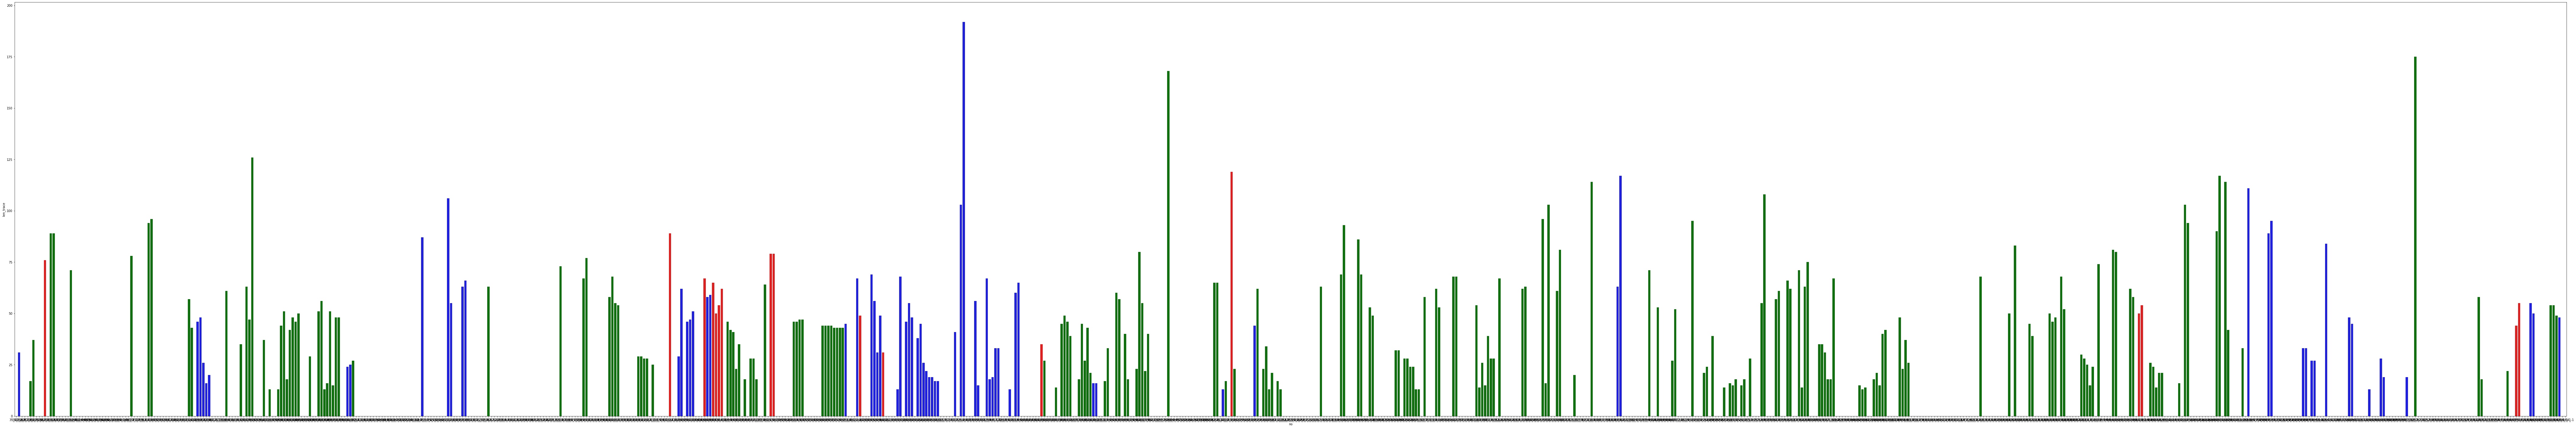

In [76]:
plt.figure(figsize=(150, 25))
ax = sns.barplot(x=plt_data['no'], y=plt_data[plt_data['kind'] == 'IN']['len_trace'], color='red')
ax = sns.barplot(x=plt_data['no'], y=plt_data[plt_data['kind'] == 'TP']['len_trace'], color='green')
ax = sns.barplot(x=plt_data['no'], y=plt_data[plt_data['kind'] == 'FN']['len_trace'], color='blue')
# for bar in ax.patches:
#     x = bar.get_x()
#     width = bar.get_width()
#     centre = x + width/2
#     bar.set_x(centre - 0.4)
#     bar.set_width(0.8)
# plt.gca().set_xlim(-1,32) 
plt.show()

ValueError: 'explode' must be of length 'x'

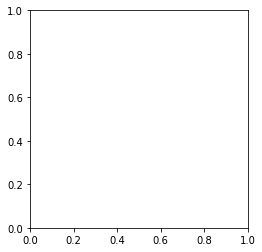

In [77]:
freq = plt_data['kind'].value_counts()
plt.pie(freq, labels=freq.index, explode=(0.05, 0, 0), autopct='%.1f%%',
        colors=['#81ecec','#ff7675','#6c5ce7'], startangle=90, counterclock=False)
plt.show()


In [ ]:
plt_data.to_csv('plt_data.csv', index=False)

In [ ]:
plt_data.head()

,no,len_trace,kind
3054,55_02_-1,31,TP
7142,272_02_-1,37,TP
34914,44_06_-1,71,TP
91497,1017_07_-1,46,TP
91837,1029_07_-1,48,TP


In [ ]:
len([i for i in tp_ls if i not in no]), len(tp_ls), len(no)

(48, 237, 472)

In [ ]:
len([i for i in tp_ls if i not in all_real_ls]), len(tp_ls), len(all_real_ls)

(0, 237, 760)

In [ ]:
len([i for i in fp_ls if i not in all_real_ls]), len(fp_ls), len(all_real_ls)

(0, 295, 760)

In [ ]:
200/(217)

0.9216589861751152